# 1) Imports

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster import silhouette_visualizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

warnings.filterwarnings("ignore")

# 2) Coleta dos Dados

In [11]:
df = pd.read_csv(r'../Dados/Tabela_final/tabela_final.csv')
df.head()

,IBGE7,UF,NOME,LATITUDE,LONGITUDE,DIST_EF_PUB,DIST_EM_PUB,IDEB_AI,IDEB_AF,DOCSUP_EF_PUB,...,T_ANALF18A24,T_ANALF18M,T_ANALF25A29,T_ANALF25M,RDPC,QUAL_MED_AGUA,DIST_CORPO_AGUA,TRANSPORT_COST,TOT_ESC_POR_POP,TOT_MAT_POR_POP
0,2700300,AL,ARAPIRACA,-9.75487,-36.6615,28.884,43.100,4.580,3.624,54.40,...,6.27,24.10,11.76,28.61,423.28,62.268456,42.035186,24042.166072,0.000433,0.245423
1,2700706,AL,BATALHA,-9.67420,-37.1330,31.100,35.892,4.544,3.632,12.62,...,8.85,33.44,20.53,40.54,265.62,66.758485,24.642419,24257.110578,0.001200,0.384829
2,2700904,AL,BELO MONTE,-9.82272,-37.2770,36.412,54.792,3.928,3.044,27.12,...,12.42,41.81,30.29,49.99,187.77,66.758485,3.297594,24226.863743,0.002235,0.298063
3,2701209,AL,CACIMBINHAS,-9.40121,-36.9911,38.284,40.720,4.164,3.324,49.04,...,13.56,43.81,30.14,51.12,259.72,66.758485,58.541833,24358.206538,0.001102,0.419781
4,2701605,AL,CANAPI,-9.11932,-37.5967,31.024,38.636,4.584,3.580,20.84,...,15.27,44.16,28.31,51.97,183.83,71.338777,68.942666,24734.221802,0.002032,0.366838


# 2) Análise Exploratória

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 62 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   IBGE7                1261 non-null   int64  
 1   UF                   1261 non-null   object 
 2   NOME                 1261 non-null   object 
 3   LATITUDE             1261 non-null   float64
 4   LONGITUDE            1261 non-null   float64
 5   DIST_EF_PUB          1261 non-null   float64
 6   DIST_EM_PUB          1261 non-null   float64
 7   IDEB_AI              1261 non-null   float64
 8   IDEB_AF              1261 non-null   float64
 9   DOCSUP_EF_PUB        1261 non-null   float64
 10  DOCSUP_EM_PUB        1261 non-null   float64
 11  TXNASC7C             1261 non-null   float64
 12  TXNBAIXOP            1261 non-null   float64
 13  PINTERSAP            1261 non-null   float64
 14  PINTERDRSAI          1261 non-null   float64
 15  PDEFAGUA             1261 non-null   f

In [13]:
columns = [coluna for coluna in df.columns if (df[coluna].dtype == 'float64')&(coluna not in ['LATITUDE', 'LONGITUDE'])]

In [14]:
class Subplots:
    def __init__(self, n_linhas, n_colunas) -> None:
        self.n_colunas = n_colunas
        self.n_linhas = n_linhas
    
    
    def violin(self, df, altura=35, comprimento=20):
        fig, ax = plt.subplots(ncols=self.n_colunas, nrows=self.n_linhas, sharex=False, sharey=False, figsize=(comprimento, altura))
        for linha in range(self.n_linhas):
            for coluna in range(self.n_colunas):
                index_coluna = linha * self.n_colunas + coluna
                if index_coluna < len(columns): 
                    sns.violinplot(x=df[df.columns[index_coluna]], color='skyblue', ax=ax[linha][coluna])
                    ax[linha][coluna].set_title(f'Distribuição de {df.columns[index_coluna]}')  # Título do gráfico
                    ax[linha][coluna].set_xlabel("Value")
                    ax[linha][coluna].set_ylabel("Distribution")
                else:
                    ax[linha][coluna].set_visible(False)
        plt.tight_layout()
        plt.show()


    def box(self, df, altura=35, comprimento=20):
        fig, ax = plt.subplots(ncols=self.n_colunas, nrows=self.n_linhas, sharex=False, sharey=False, figsize=(comprimento, altura))
        for linha in range(self.n_linhas):
            for coluna in range(self.n_colunas):
                index_coluna = linha * self.n_colunas + coluna
                if index_coluna < len(columns): 
                    sns.boxplot(x=df[df.columns[index_coluna]], color='skyblue', ax=ax[linha][coluna])
                    ax[linha][coluna].set_title(f'Distribuição de {df.columns[index_coluna]}')  # Título do gráfico
                    ax[linha][coluna].set_xlabel("Value")
                    ax[linha][coluna].set_ylabel("Distribution")
                else:
                    ax[linha][coluna].set_visible(False)
        plt.tight_layout()
        plt.show()

In [15]:
sub = Subplots(10, 6)

Avaliando distribuições

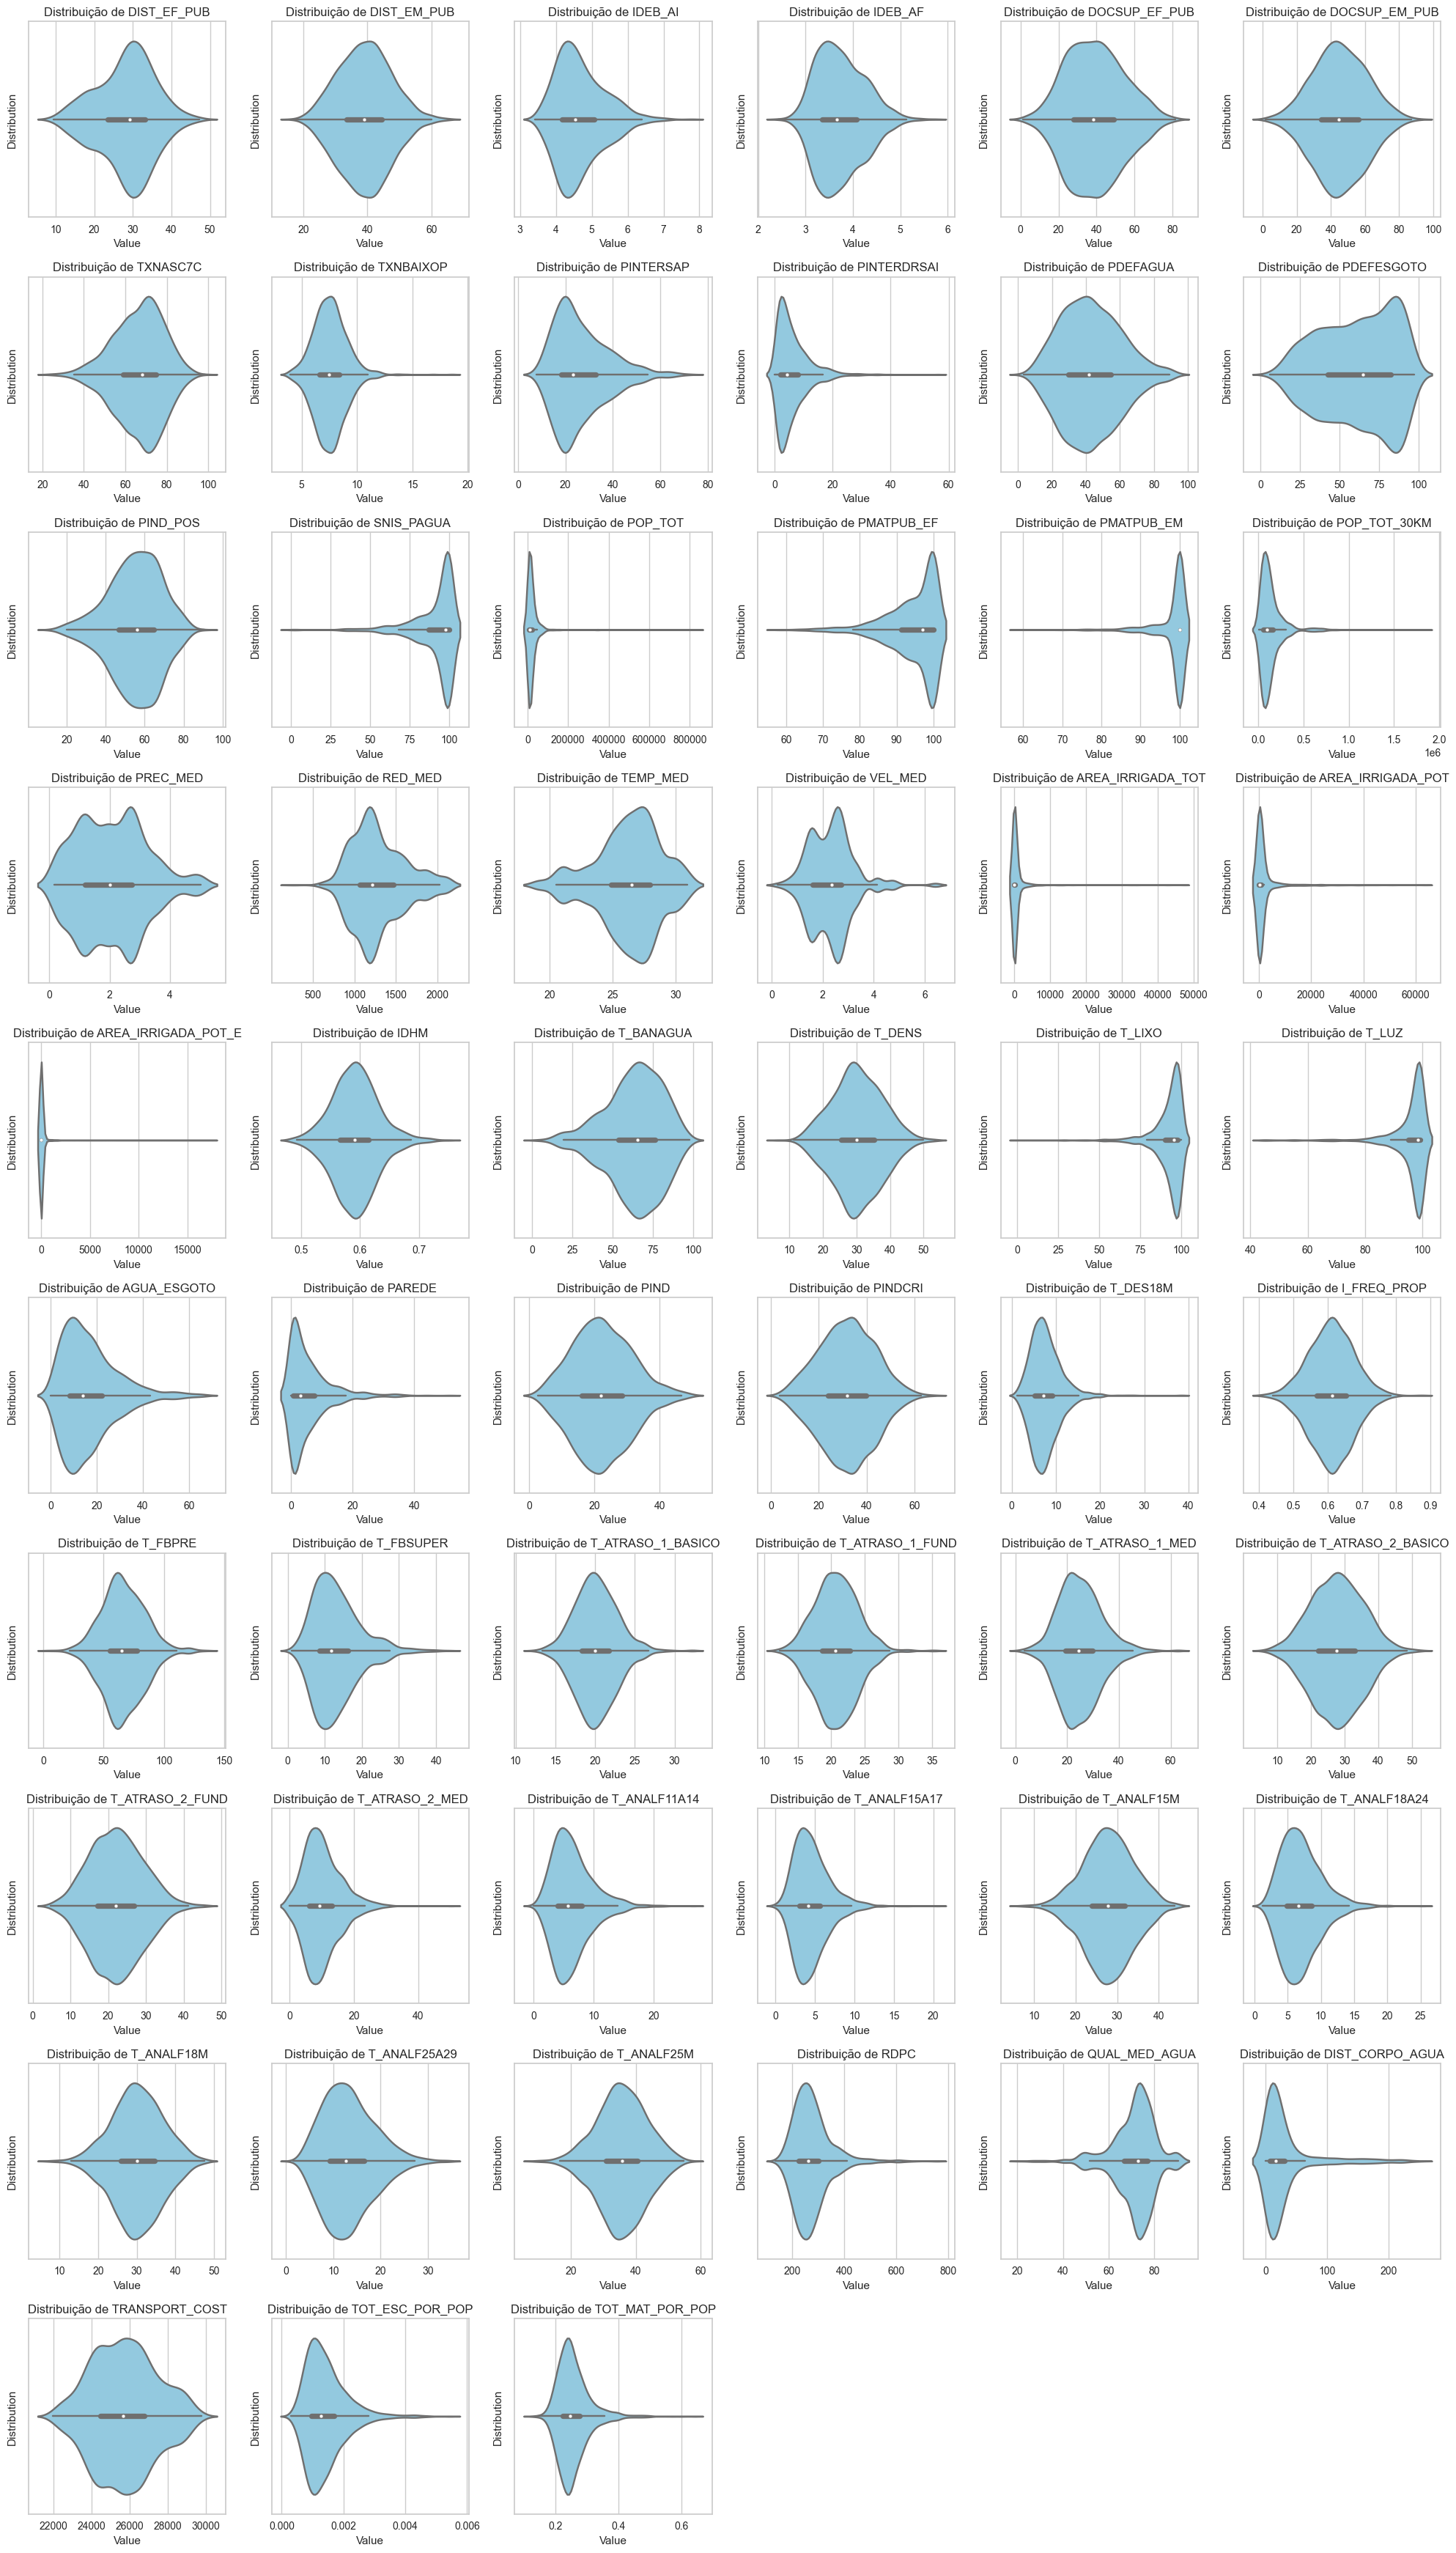

In [16]:
sub.violin(df[columns])

Avaliando Outliers

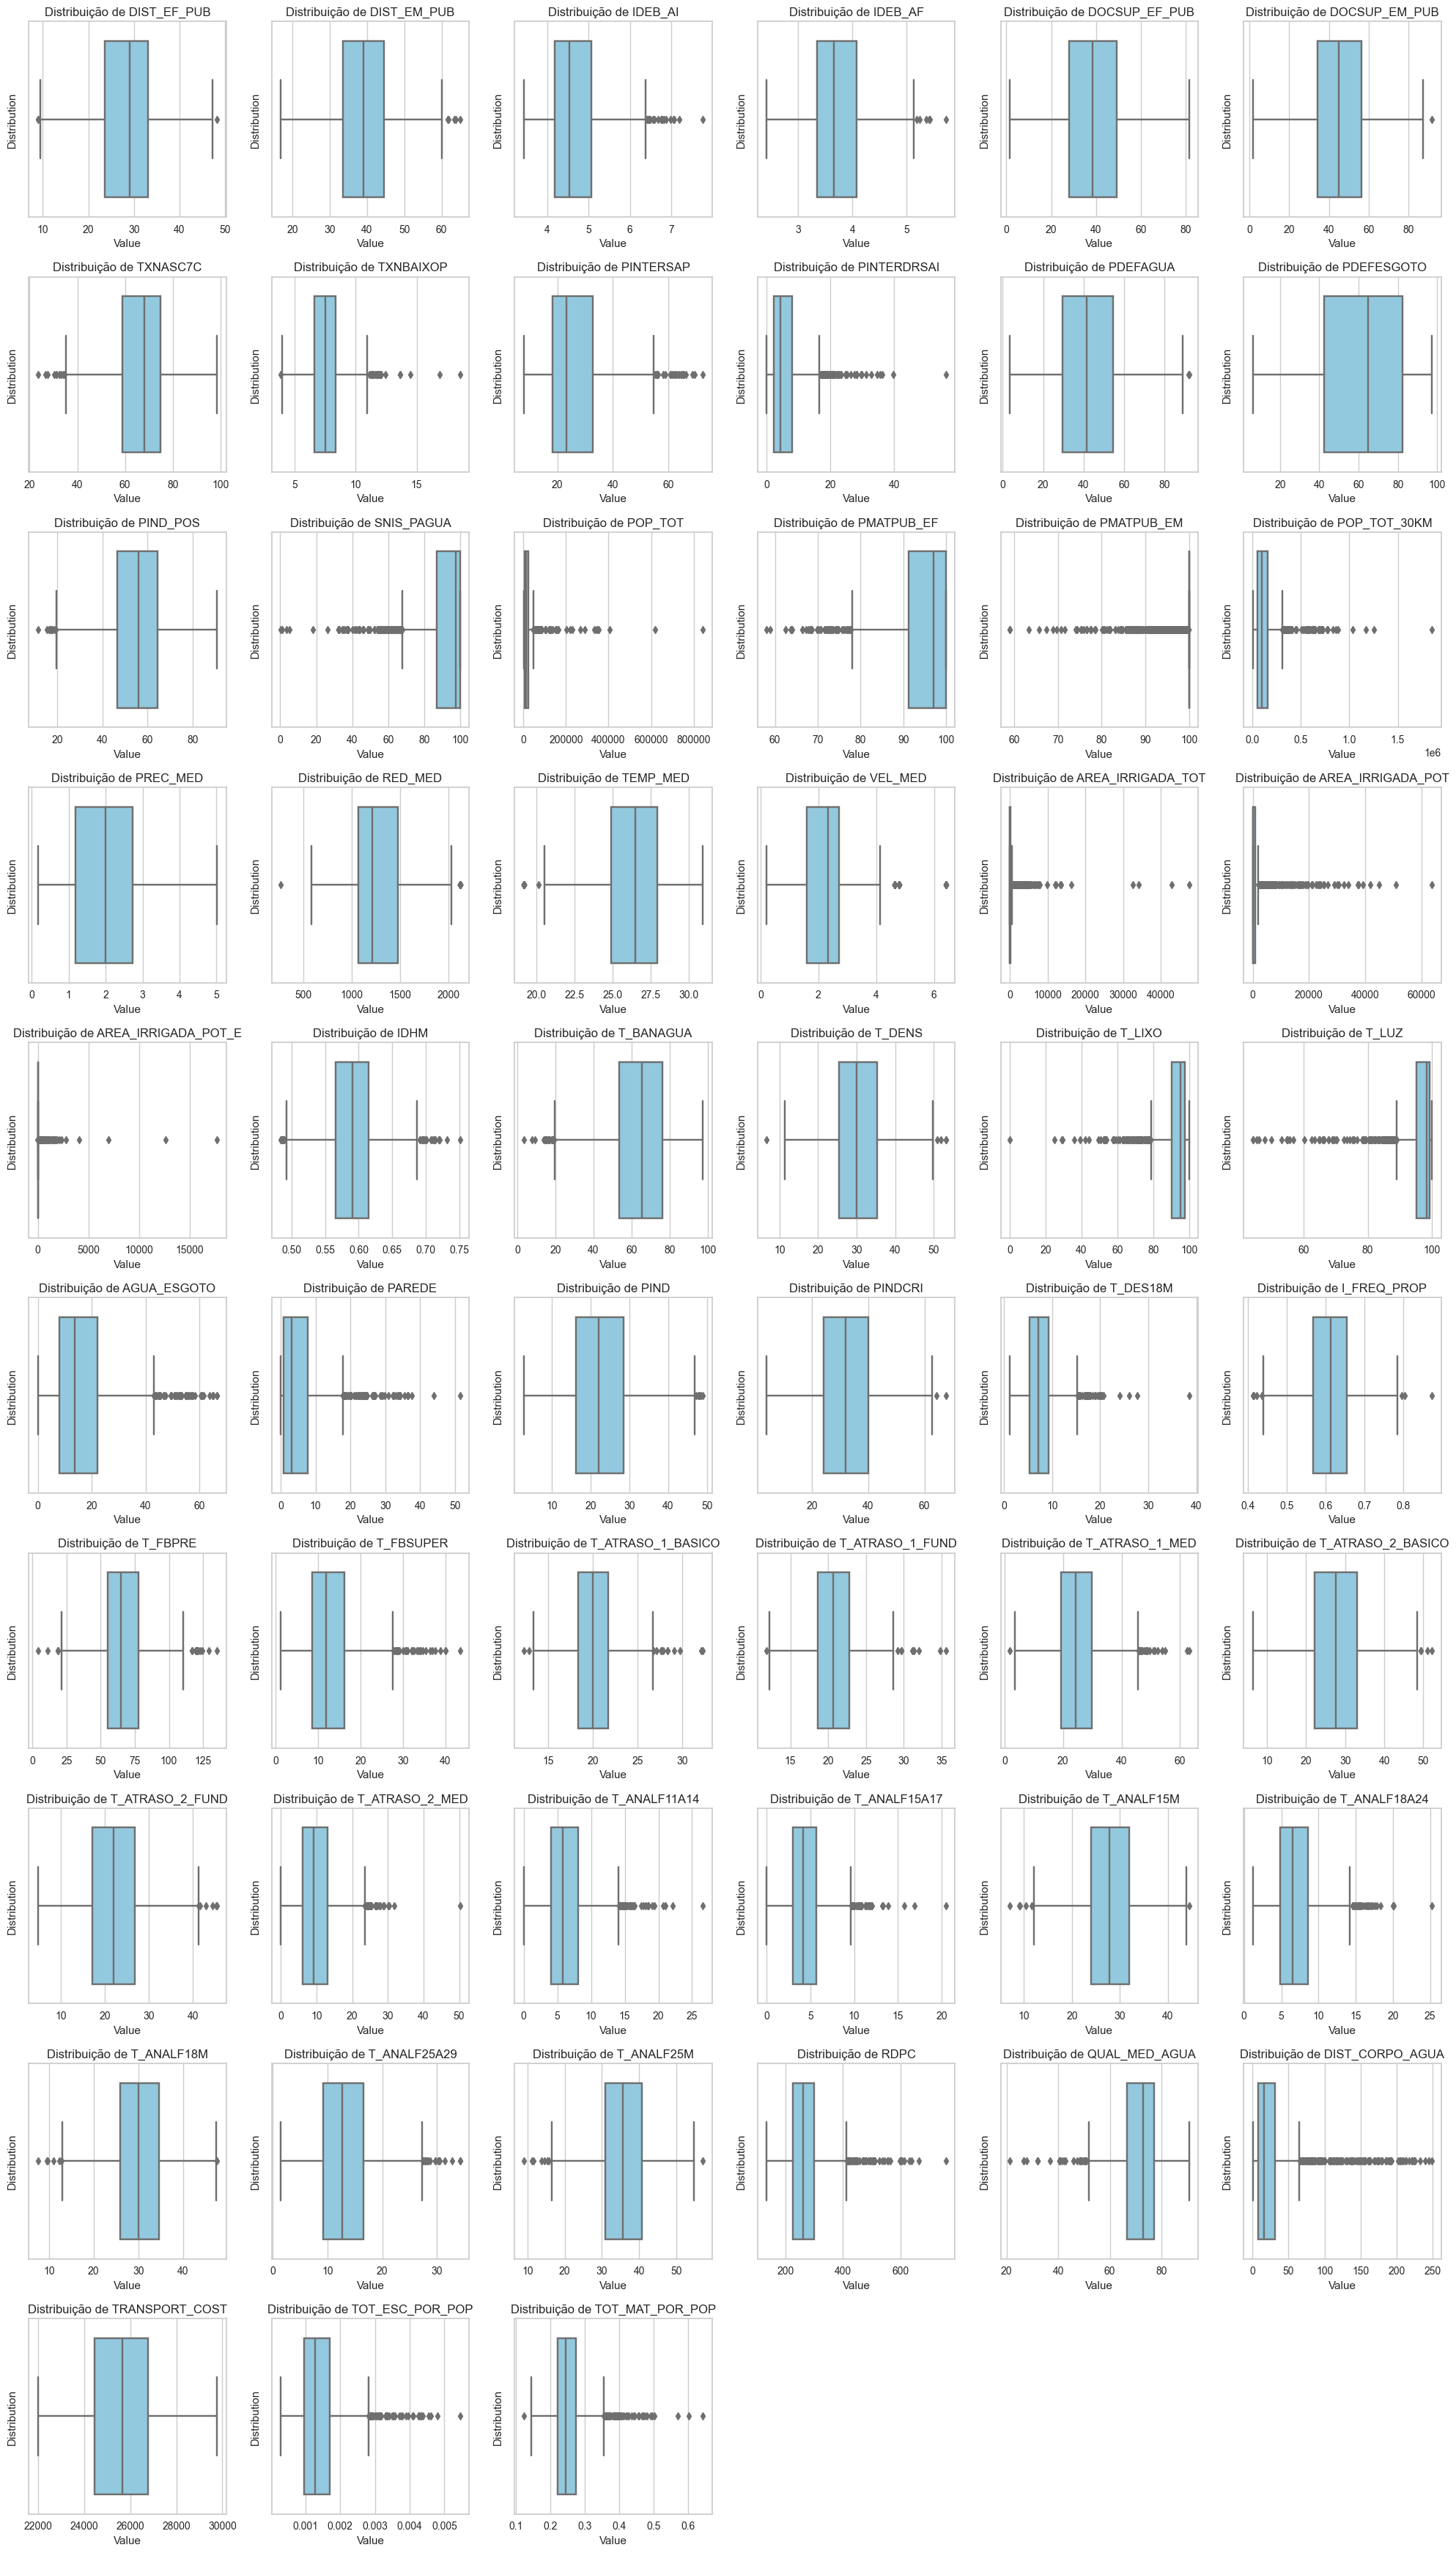

In [17]:
sub.box(df[columns])

# 3) Redução da dimensinalidade e análise de cluster

## 3.1) Pré-processamento

In [18]:
df_numeric_features = df[columns].copy()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric_features)

## 3.2) Aplicação do PCA

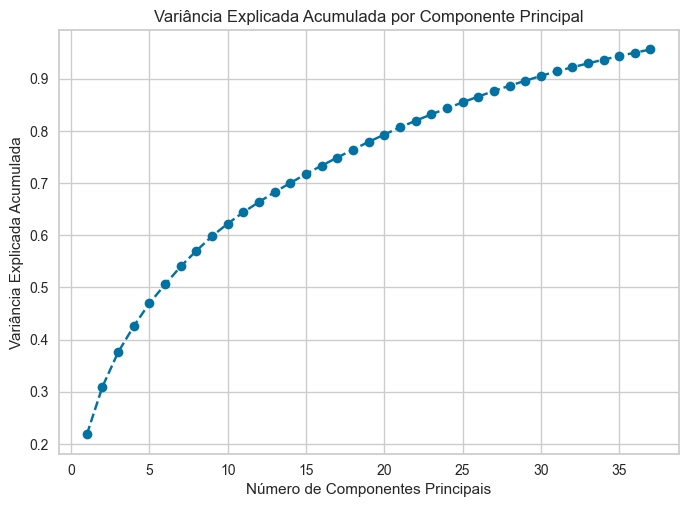

In [19]:
pca = PCA(n_components = 0.95)
df_reducted = pca.fit_transform(df_scaled)

variancia_explicada = pca.explained_variance_ratio_

variancia_acumulada = np.cumsum(variancia_explicada)
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por Componente Principal')
plt.show()

## 3.3) Análise de cluster

In [20]:
tsne = TSNE(n_components=2, random_state=42)
df_components = tsne.fit_transform(df_scaled)
df_components = pd.DataFrame(df_components)
df_components.columns = ['COMPONENT1', 'COMPONENT2']

def plot(df, df_components, clusters):
    df = pd.concat([df, df_components], axis = 1)
    df['CLUSTER'] = clusters

    actual_cities = df[
        [
            'NOME', 
            'COMPONENT1', 
            'COMPONENT2', 
            'CLUSTER'
        ]
    ].loc[
        df['NOME'].isin(
            [
                'MAURITI', 
                'SAO JOSE DA TAPERA', 
                'BUIQUE', 
                'INAJA'
            ]
        )
    ]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df, 
        x='COMPONENT1', 
        y='COMPONENT2', 
        hue='CLUSTER', 
        palette='Set2'
    )
    sns.scatterplot(
        data=actual_cities, 
        x='COMPONENT1', 
        y='COMPONENT2', 
        marker = 'X', 
        color='black', 
        s=100, 
        label='Cidades atuais'
    )
    for i, row in actual_cities.iterrows():
        plt.text(row['COMPONENT1'] + 0.1, row['COMPONENT2'], row['NOME'], fontsize=12)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.title('Visualização dos Clusters')
    plt.legend(title='Cluster', loc='upper right')
    plt.grid(True)
    plt.show()

### 3.3.1) Hierarchical Clustering

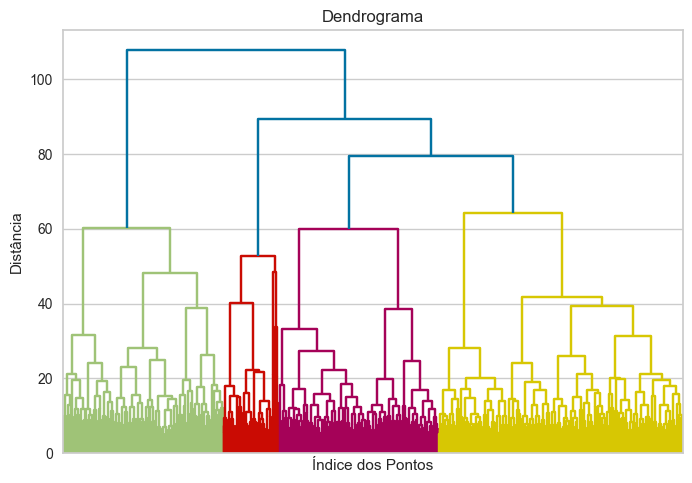

In [21]:
linkage_matrix = linkage(df_reducted, method='ward')

plt.figure()
dendrogram(linkage_matrix)
plt.title('Dendrograma')
plt.xticks([])
plt.xlabel('Índice dos Pontos')
plt.ylabel('Distância')
plt.show()

Silhouette Score:  0.1012
Davies-Bouldin Score:  2.8019
Calinski-Harabasz Index:  115.8656


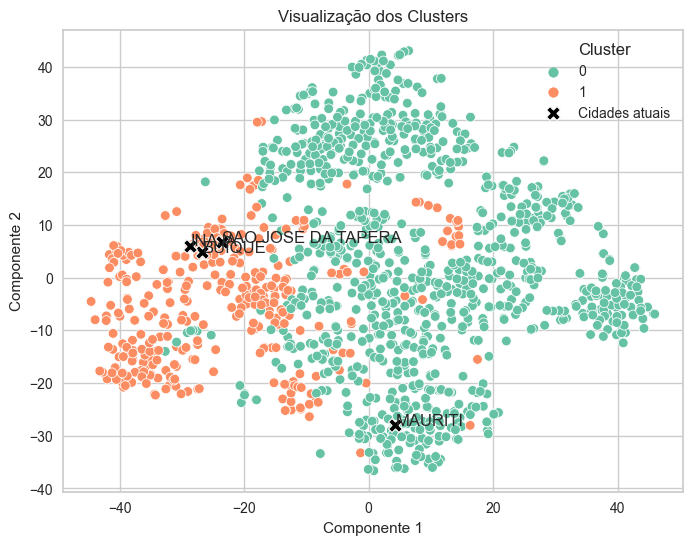

In [22]:
hclustering = AgglomerativeClustering(n_clusters=2)
h_clusters = hclustering.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, h_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, h_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, h_clusters),4))
plot(df, df_components, h_clusters)

### 3.3.2) K-Means

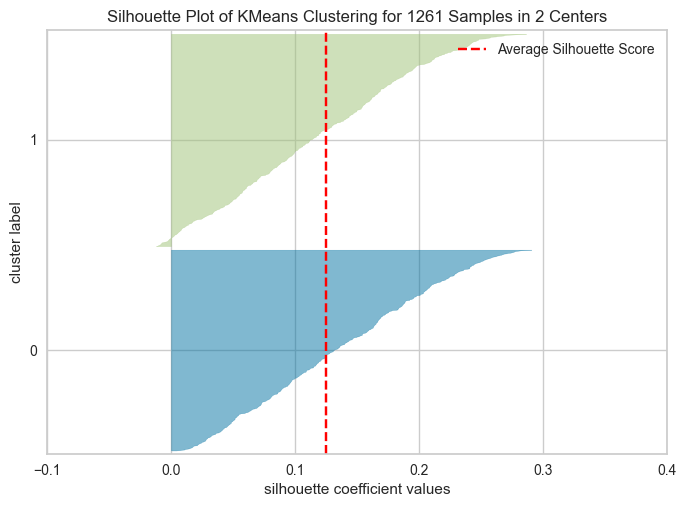

In [23]:
best_score = -1  
best_n_clusters = 0  
for n_clusters in range(2,50):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_reducted)
    score = silhouette_score(df_reducted, clusters)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
        
silhouette_visualizer(KMeans(best_n_clusters, random_state=42), df_reducted, colors='yellowbrick')
plt.show()

Silhouette Score:  0.1253
Davies-Bouldin Score:  2.3654
Calinski-Harabasz Index:  207.4554


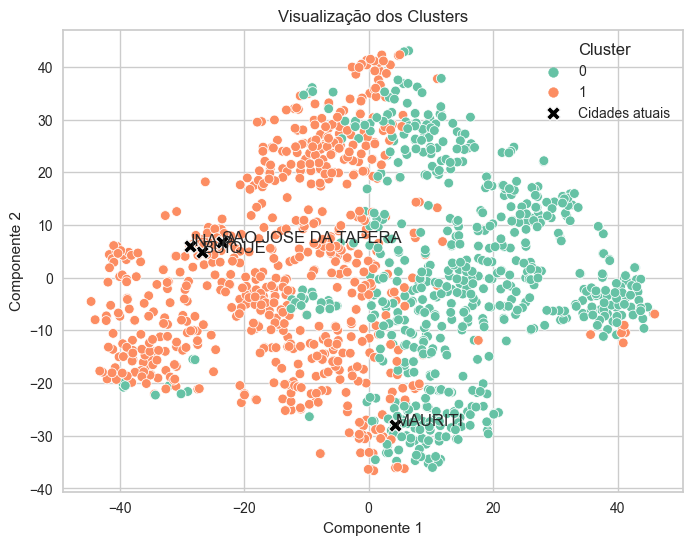

In [24]:
kmeans = KMeans(2, random_state = 42)
k_clusters = kmeans.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, k_clusters),4))
plot(df, df_components, k_clusters)

## 3.4) Seleção das melhores features

In [25]:
X = df[columns]
y = k_clusters

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)
boruta = BorutaPy(rf_model, n_estimators='auto', verbose=False, random_state=42)
boruta.fit(X_train.values, y_train)
mask_columns_selected = boruta.support_.tolist()
df_pp = X.iloc[:, mask_columns_selected]
columns_selected = df_pp.columns
columns_selected

Index(['DIST_EF_PUB', 'DIST_EM_PUB', 'IDEB_AI', 'IDEB_AF', 'DOCSUP_EF_PUB',
       'DOCSUP_EM_PUB', 'TXNASC7C', 'PDEFAGUA', 'PDEFESGOTO', 'PIND_POS',
       'PMATPUB_EF', 'IDHM', 'T_BANAGUA', 'T_DENS', 'T_LUZ', 'AGUA_ESGOTO',
       'PIND', 'PINDCRI', 'I_FREQ_PROP', 'T_FBSUPER', 'T_ATRASO_1_BASICO',
       'T_ATRASO_1_FUND', 'T_ATRASO_1_MED', 'T_ATRASO_2_BASICO',
       'T_ATRASO_2_FUND', 'T_ATRASO_2_MED', 'T_ANALF11A14', 'T_ANALF15A17',
       'T_ANALF15M', 'T_ANALF18A24', 'T_ANALF18M', 'T_ANALF25A29',
       'T_ANALF25M', 'RDPC', 'TOT_ESC_POR_POP'],
      dtype='object')

## 3.5) Pré-processamento

In [26]:
df_best_features = df[columns_selected].copy()
df_scaled = scaler.fit_transform(df_best_features)

## 3.6) Nova aplicação do PCA

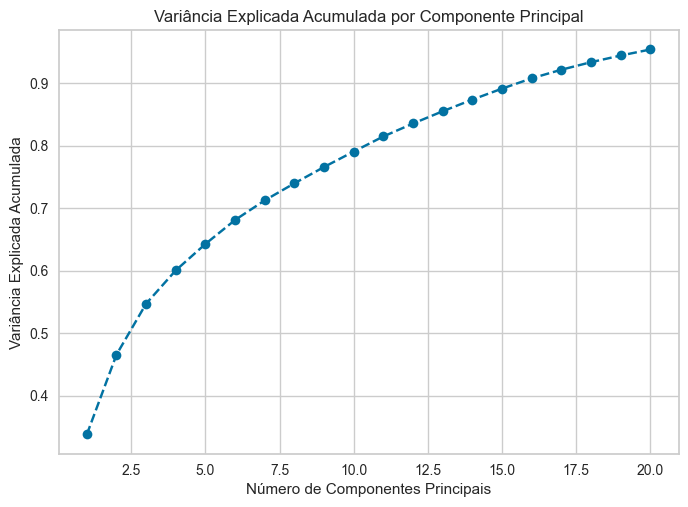

In [27]:
df_reducted = pca.fit_transform(df_scaled)

variancia_explicada = pca.explained_variance_ratio_

variancia_acumulada = np.cumsum(variancia_explicada)
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por Componente Principal')
plt.show()

## 3.6) Nova análise de cluster

In [28]:
df_components = tsne.fit_transform(df_scaled)
df_components = pd.DataFrame(df_components)
df_components.columns = ['COMPONENT1', 'COMPONENT2']

### 3.6.1) Hierachical Clustering

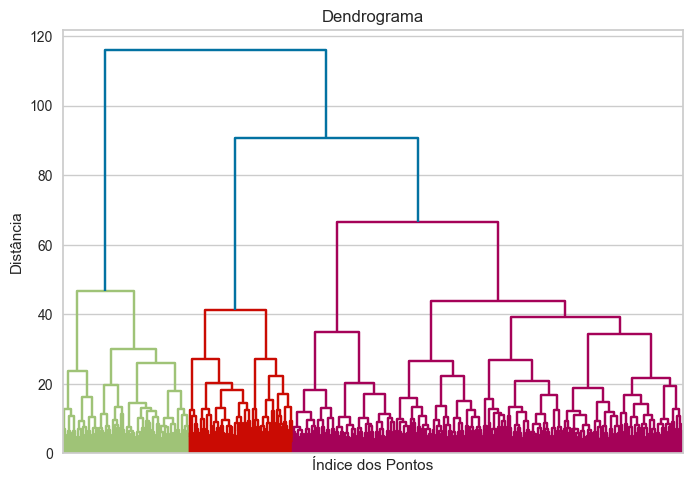

In [29]:
linkage_matrix = linkage(df_reducted, method='ward')

plt.figure()
dendrogram(linkage_matrix)
plt.title('Dendrograma')
plt.xticks([])
plt.xlabel('Índice dos Pontos')
plt.ylabel('Distância')
plt.show()

Silhouette Score:  0.1657
Davies-Bouldin Score:  1.7477
Calinski-Harabasz Index:  239.121


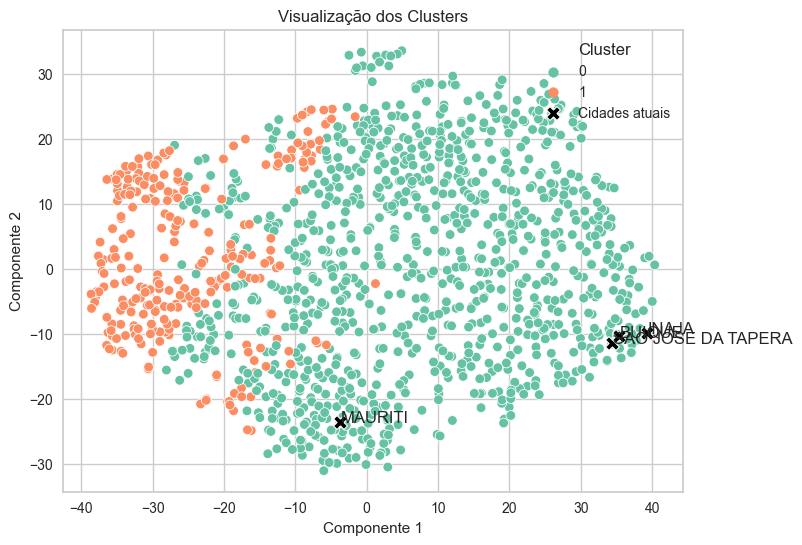

In [30]:
hclustering = AgglomerativeClustering(n_clusters=2)
h_clusters = hclustering.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, h_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, h_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, h_clusters),4))
plot(df, df_components, h_clusters)

### 3.6.2) K-Means

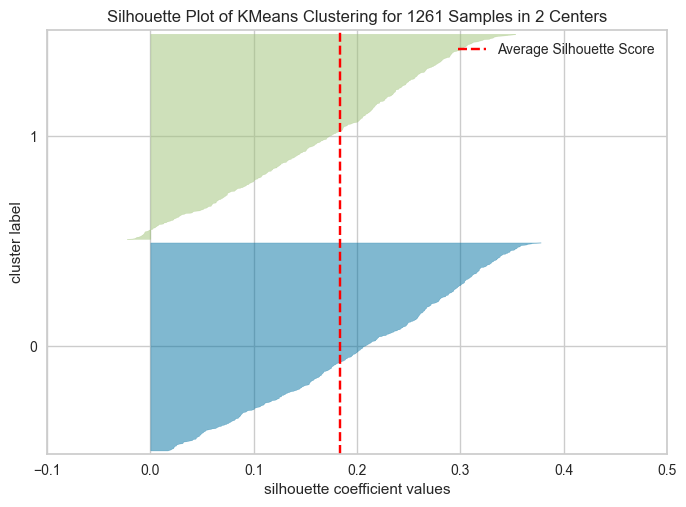

In [31]:
best_score = -1  
best_n_clusters = 0  
for n_clusters in range(2,50):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_reducted)
    score = silhouette_score(df_reducted, clusters)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
        
silhouette_visualizer(KMeans(best_n_clusters, random_state=42), df_reducted, colors='yellowbrick')
plt.show()

Silhouette Score:  0.1837
Davies-Bouldin Score:  1.8155
Calinski-Harabasz Index:  359.2422


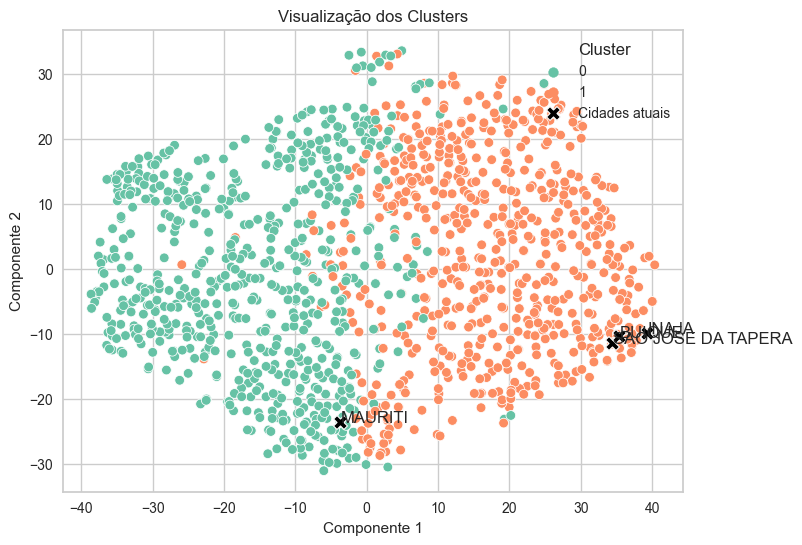

In [32]:
kmeans = KMeans(2, random_state = 42)
k_clusters = kmeans.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, k_clusters),4))
plot(df, df_components, k_clusters)

## 3.4) Seleção dos municípios com maior potencial

### 3.4.1) Interpretação dos clusters

In [33]:
df['CLUSTER'] = k_clusters
df[
    [
        'CLUSTER',
        'IDHM',
        'POP_TOT', 
        'POP_TOT_30KM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND'
    ]
].groupby('CLUSTER').mean()

,IDHM,POP_TOT,POP_TOT_30KM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND
CLUSTER,,,,,,,,
0,0.618638,29299.297323,149941.100787,308.98737,24.351433,0.650710,7.788646,17.618079
1,0.564149,14319.606709,119873.102875,235.98155,31.445335,0.570254,7.441741,27.219026


### 3.4.1) Interpretação dos municípios atuais

In [34]:
actual_cities = df[
    [
        'NOME', 
        'IDHM',
        'POP_TOT', 
        'POP_TOT_30KM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND',
        'CLUSTER'
    ]
].loc[df['NOME'].isin(['MAURITI', 'SAO JOSE DA TAPERA', 'BUIQUE', 'INAJA'])]

actual_cities

,NOME,IDHM,POP_TOT,POP_TOT_30KM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND,CLUSTER
34,SAO JOSE DA TAPERA,0.527,32258.8,225558.2,188.84,37.04,0.536,4.33,39.70,1
418,MAURITI,0.605,46103.4,207315.4,236.11,29.51,0.632,8.31,29.78,0
796,BUIQUE,0.527,56502.4,234399.4,176.76,40.18,0.524,7.25,38.73,1
827,INAJA,0.523,21917.0,89734.8,182.73,35.98,0.471,7.35,41.19,1


### 3.4.1) Seleção dos municipios de maior potencial

In [35]:
potential_muns = df.copy()

potential_muns = potential_muns[
    [
        'IBGE7',
        'NOME', 
        'UF',
        'IDHM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND'
    ]
].loc[
    (potential_muns['CLUSTER'] == 1)&
    (potential_muns['POP_TOT'] >= 21917)&
    (potential_muns['POP_TOT_30KM'] >= 89734)&
    ~(potential_muns['NOME'].isin(['MAURITI', 'SAO JOSE DA TAPERA', 'BUIQUE', 'INAJA']))
].sort_values(by='IDHM').reset_index().drop(columns='index')

potential_muns

,IBGE7,NOME,UF,IDHM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND
0,2916500,ITAPICURU,BA,0.486,185.70,38.52,0.462,9.86,31.44
1,2705002,MATA GRANDE,AL,0.504,186.87,38.79,0.499,1.57,41.39
2,2921500,MONTE SANTO,BA,0.506,197.43,35.57,0.494,4.55,35.11
3,2607505,ITAIBA,PE,0.510,218.32,39.73,0.497,4.11,27.48
4,2615805,TUPANATINGA,PE,0.519,172.52,38.41,0.513,5.31,45.08
...,...,...,...,...,...,...,...,...,...
71,2601102,ARARIPINA,PE,0.602,324.01,25.33,0.563,5.40,17.75
72,2904100,BOQUIRA,BA,0.603,266.71,25.81,0.607,10.26,27.30
73,2305407,ICO,CE,0.606,274.01,32.83,0.649,5.53,24.65
74,2407807,MONTE ALEGRE,RN,0.609,292.15,28.92,0.623,11.57,15.17


In [36]:
final_df = df[df['IBGE7'].isin(potential_muns['IBGE7'])].sort_values(by='IDHM').reset_index().drop(columns='index')
final_df.to_csv('../Dados/Tabela_final/municipios_potenciais.csv')

### 3.4.1) Identificação do município mais prioritário

In [37]:
scaler = MinMaxScaler()
best_mun = potential_muns.copy()
for column in ['IDHM','RDPC','I_FREQ_PROP']:
    best_mun[column] = 1/best_mun[column]
num_metrics = ['IDHM','RDPC', 'T_ANALF15M', 'I_FREQ_PROP', 'T_DES18M','PIND']
best_mun[num_metrics] = scaler.fit_transform(best_mun[num_metrics])
best_mun['SCORE'] = best_mun['IDHM'] +best_mun['RDPC'] +best_mun['T_ANALF15M'] +best_mun['I_FREQ_PROP'] + best_mun['T_DES18M'] + best_mun['PIND']
best_mun['SCORE'] = best_mun['SCORE']
best_mun[num_metrics] = best_mun[num_metrics].rank(ascending=False)
best_mun.sort_values(by='SCORE', ascending= False).head(10).reset_index().drop(columns='index')

,IBGE7,NOME,UF,IDHM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND,SCORE
0,2916500,ITAPICURU,BA,1.0,8.0,8.0,1.0,9.0,18.0,5.012068
1,2615805,TUPANATINGA,PE,5.0,1.0,9.0,14.0,59.0,2.0,4.485473
2,2709202,TRAIPU,AL,11.0,6.0,1.0,17.0,74.0,1.0,4.340339
3,2702900,GIRAU DO PONCIANO,AL,13.0,5.0,13.0,18.5,21.0,8.0,4.223194
4,2100907,ARAIOSES,MA,6.0,3.0,22.0,20.5,28.0,7.0,4.215621
5,2603207,CAETES,PE,7.0,4.0,6.0,20.5,73.0,4.0,4.117137
6,2705002,MATA GRANDE,AL,2.0,9.0,5.0,12.5,76.0,6.0,4.094381
7,2805406,POCO REDONDO,SE,10.0,12.0,15.0,7.0,43.0,11.0,4.007512
8,2921500,MONTE SANTO,BA,3.0,10.0,16.0,8.0,69.0,12.0,3.968699
9,2600500,AGUAS BELAS,PE,9.0,31.0,2.0,5.0,40.0,15.0,3.913774
